In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import networkx as nx
from statannot import add_stat_annotation

In [9]:
def liu_driver_nodes(G):
    from hopcroftkarp import HopcroftKarp
    bipartite = {}
    for node in G:
        bipartite[str(node)+'*'] = set(G.successors(node))
    
    max_matching = HopcroftKarp(bipartite).maximum_matching()
    matched_node = []
    for value in max_matching.values():
        if value in G.nodes:
            matched_node.append(value)
        else:
            continue
            
    return len(G) - len(matched_node)

In [12]:
def indispensable_nodes(G, read_nodes):
    original_number_unmatched_nodes = liu_driver_nodes(G)
    mutated_number_unmatched_nodes = dict()
    
    for node in read_nodes:
        Gcopy = G.copy()
        Gcopy.remove_node(node)
        mutated_number_unmatched_nodes[node] = liu_driver_nodes(Gcopy)
        
    indispensable = [read_nodes[x] for x, val in mutated_number_unmatched_nodes.items()
                    if val > original_number_unmatched_nodes]
    dispensable = [read_nodes[x] for x, val in mutated_number_unmatched_nodes.items()
                    if val < original_number_unmatched_nodes]
    neutral = [read_nodes[x] for x, val in mutated_number_unmatched_nodes.items()
                    if val == original_number_unmatched_nodes]
    
    return{'indispensable': indispensable,
          'dispensable': dispensable,
          'neutral': neutral}

In [4]:
networkModel =['bortezomib',
                # 'igvh',
                'apoptosis',
                # 'aurora',
                'bt474_long',
                'bt474_short',
                # 'cd4t',
                'colitis',
                'death',
                # 'egfr',
                # 'erbb',
                # 'fa_brca',
                # 'fa_check',
                'hcc1954_long',
                'hcc1954_short',
                'hgf',
                'mammalian',
                # 'mammalian_2006',
                'mapk',
                'oxidative',
                # 'pro_inflammatory',
                'fibroblasts',
                'skbr3_long',
                'skbr3_short',
                'tlgl_2008',
                'tlgl_2011',
                # 'tlgl_2011_reduced',
                # 'prostate',
                'migration']

In [13]:
Prefix, Suffix = 'n', 'n'
TEMP = jR.cellcollective(networkModel[0], Prefix, Suffix, directory='../')

BooleanRuleFileName = TEMP['BooleanRule_filename']
network_name = TEMP['network_name']

NumInputs = TEMP['num_inputs']
NumInputConditions = TEMP['num_input_conditions']

InputConditions = TEMP['input_conditions']

OutputNodes = TEMP['output_nodes']
InputNodes = TEMP['input_nodes']

Mapping = TEMP['mapping']
InverseMapping = TEMP['inverse_mapping']
GRead = TEMP['Gread']
ReadNodes = TEMP['read_nodes']

integrated_data = pd.read_csv('../data/' + network_name + '_table_for_original_network.tsv', sep='\t').sort_values(by='node').set_index('node')

results = indispensable_nodes(GRead, ReadNodes)

In [19]:
indispensability = {}
for node in results['indispensable']:
    indispensability[node] = 'indispensable'
for node in results['dispensable']:
    indispensability[node] = 'dispensable'
for node in results['neutral']:
    indispensability[node] = 'neutral'


In [20]:
integrated_data['indispensability'] = pd.Series(indispensability)

In [22]:
integrated_data.reset_index(inplace=True)

In [23]:
for Model in networkModel[1:]:
    Prefix, Suffix = 'n', 'n'
    TEMP = jR.cellcollective(Model, Prefix, Suffix, directory='../')

    BooleanRuleFileName = TEMP['BooleanRule_filename']
    network_name = TEMP['network_name']

    NumInputs = TEMP['num_inputs']
    NumInputConditions = TEMP['num_input_conditions']

    InputConditions = TEMP['input_conditions']

    OutputNodes = TEMP['output_nodes']
    InputNodes = TEMP['input_nodes']
    
    Mapping = TEMP['mapping']
    InverseMapping = TEMP['inverse_mapping']
    GRead = TEMP['Gread']
    ReadNodes = TEMP['read_nodes']
    
#     CutOffRange = [3, 4, 5, 6, 7]
   

    table_original_network = pd.read_csv('../data/' + network_name + '_table_for_original_network.tsv', sep='\t').sort_values(by='node').set_index('node')
    
    results = indispensable_nodes(GRead, ReadNodes)
    
    indispensability = {}
    for node in results['indispensable']:
        indispensability[node] = 'indispensable'
    for node in results['dispensable']:
        indispensability[node] = 'dispensable'
    for node in results['neutral']:
        indispensability[node] = 'neutral'
    table_original_network['indispensability'] = pd.Series(indispensability)
    table_original_network['network'] = network_name
    table_original_network.reset_index(inplace=True)
    integrated_data = pd.concat([integrated_data, table_original_network], ignore_index=True)

In [24]:
df_plot = integrated_data.groupby(['Class', 'indispensability']).size().reset_index().pivot(columns='indispensability', index='Class', values=0)

<AxesSubplot:xlabel='Class'>

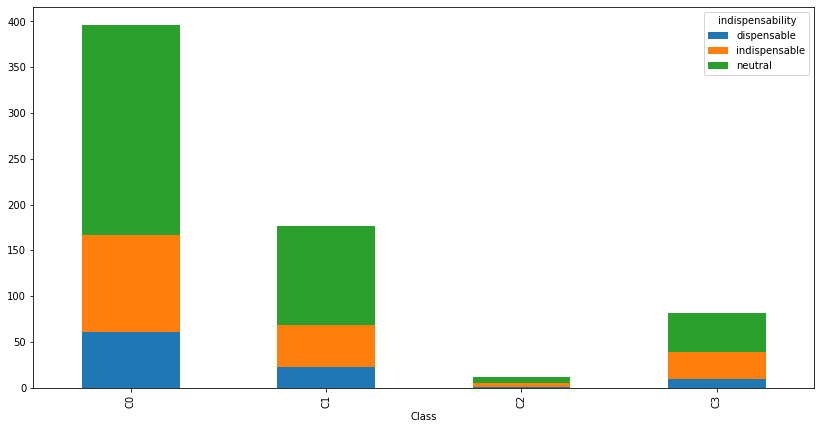

In [26]:
df_plot.plot.bar(stacked=True, figsize=(14,7))

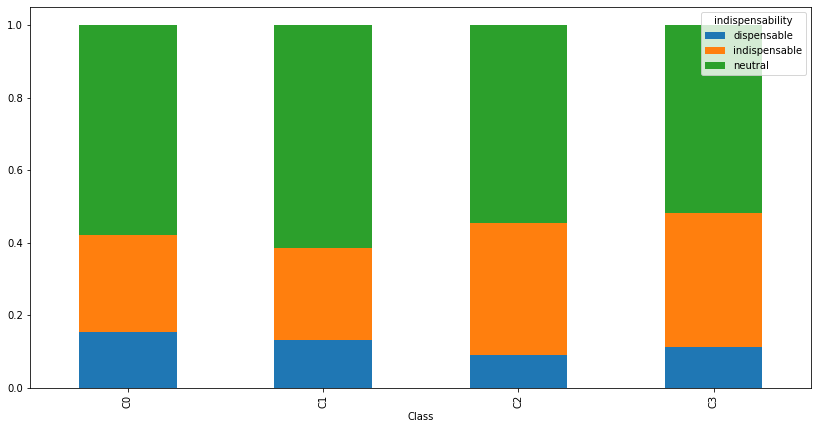

In [39]:
df_freq_plot = df_plot.fillna(0.0)
df_freq_plot = df_freq_plot.div(df_freq_plot.sum(axis=1), axis=0)
df_freq_plot.plot.bar(stacked=True, figsize=(14,7))
plt.savefig('indispensability_mapk.pdf', dpi=300)

In [31]:
test = integrated_data.groupby(['network','Class', 'indispensability']).size().reset_index().pivot(columns=['Class','indispensability'], index='network', values=0).fillna(0.0)

In [36]:
test_freq = test.div(test.sum(axis=1), axis=0)

<AxesSubplot:xlabel='network'>

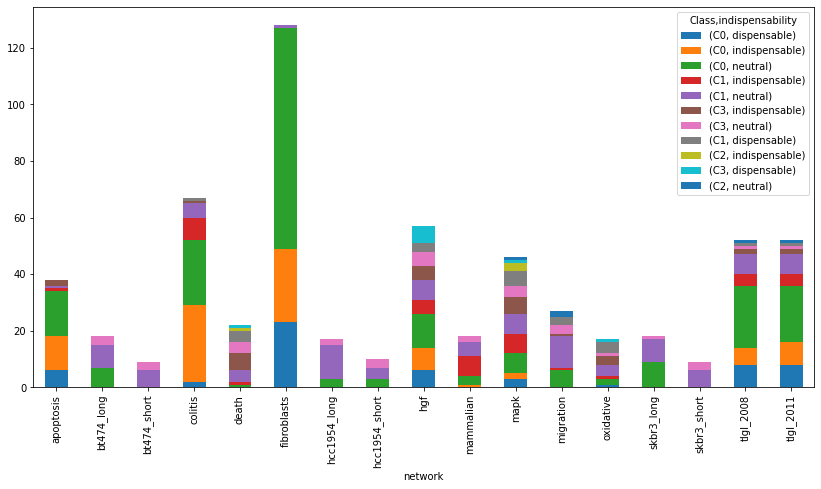

In [38]:
test.plot.bar(stacked=True, figsize=(14,7))